<p style="font-family: 'Courier New', Courier, monospace; font-size: 30px; font-weight: bold; color: blue;  text-align: left;">
 PLM Modelling and Comaprison
</p>

In [2]:
# === Libraries ===
import numpy as np  # For numerical operations
import pandas as pd  # For data manipulation and analysis
import matplotlib.pyplot as plt  # For plotting and visualizations
import matplotlib.dates as mdates  # For handling date formatting in plots
import seaborn as sns  # For enhanced data visualizations
import plotly.express as px  # For interactive data visualizations

from sklearn.model_selection import KFold, train_test_split  # For splitting data and cross-validation
from sklearn.linear_model import (
    LinearRegression, 
    Ridge, 
    Lasso, 
    ElasticNet, 
    RANSACRegressor, 
    HuberRegressor, 
    BayesianRidge,
    SGDRegressor
)
from sklearn.metrics import mean_squared_error, r2_score  # For model evaluation metrics

from scipy.optimize import (
    curve_fit, 
    least_squares, 
    minimize, 
    differential_evolution, 
    dual_annealing
)  # For curve fitting functions

import warnings  # To handle any warnings during optimization
warnings.filterwarnings('ignore')  # Suppress warnings for cleaner output


In [3]:
# Load the cleaned data by IF into 'df'
df = pd.read_csv('../all_data_files/cleaned_dataset_per_device.csv', index_col=0)

In [4]:
# === Data Preparation and Variable Definitions ===
# ----------------------------------------------------

# Assuming 'df' is your DataFrame already loaded in the environment

# Extract all necessary columns
time_all = df['time'].values
d_all = df['distance'].values
c_walls_all = df['c_walls'].values
w_walls_all = df['w_walls'].values
PL_all = df['exp_pl'].values
co2_all = df['co2'].values
humidity_all = df['humidity'].values
pm25_all = df['pm25'].values
pressure_all = df['pressure'].values
temperature_all = df['temperature'].values
snr_all = df['snr'].values

# Combine all features into a single array
all_features = np.column_stack((
    d_all, c_walls_all, w_walls_all, co2_all, humidity_all,
    pm25_all, pressure_all, temperature_all, snr_all
))

# Perform a single train-test split (80-20 split), including time
X_train_all, X_test_all, PL_train_all, PL_test_all, time_train, time_test = train_test_split(
    all_features, PL_all, time_all, test_size=0.2, random_state=50
)

# Define feature indices for the models
idx_mw = [0, 1, 2]  # Indices for LDPLM-MW: d, c_walls, w_walls
idx_ep = [0, 1, 2, 3, 4, 5, 6, 7, 8]  # Indices for LDPLM-MW-EP: all features

# Extract training and testing data for LDPLM-MW
x_train_mw = X_train_all[:, idx_mw].T  # Transpose to match original shape
x_test_mw = X_test_all[:, idx_mw].T
PL_train_mw = PL_train_all
PL_test_mw = PL_test_all

# Extract training and testing data for LDPLM-MW-EP
x_train_ep = X_train_all[:, idx_ep].T
x_test_ep = X_test_all[:, idx_ep].T
PL_train_ep = PL_train_all
PL_test_ep = PL_test_all


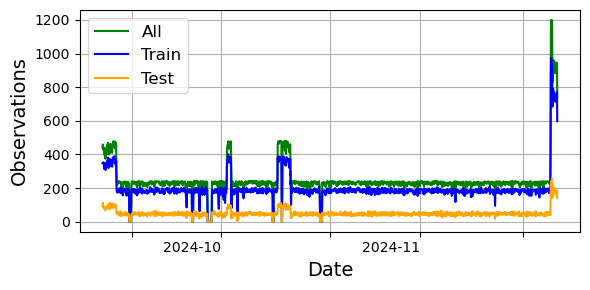

In [5]:
# === Analyzing Temporal Distribution in Training and Testing Sets ===

# Convert time arrays to pandas datetime Series
time_train = pd.to_datetime(time_train)
time_test = pd.to_datetime(time_test)

# Create DataFrames for training and testing times
train_time_df = pd.DataFrame({'time': time_train})
test_time_df = pd.DataFrame({'time': time_test})

# Remove timezone information if necessary
train_time_df['time'] = train_time_df['time'].dt.tz_localize(None)
test_time_df['time'] = test_time_df['time'].dt.tz_localize(None)

# Combine train and test times into one DataFrame with labels
train_time_df['Set'] = 'Train'
test_time_df['Set'] = 'Test'
all_time_df = pd.concat([train_time_df, test_time_df])

# Set 'time' as index
all_time_df.set_index('time', inplace=True)

# Resample counts per hour for 'All' data
all_counts = all_time_df.resample('h').size().rename('All')

# Resample counts per hour for 'Train' and 'Test' data
resampled_counts = all_time_df.groupby('Set').resample('h').size().unstack(level=0).fillna(0)

# Combine 'All' counts with 'Train' and 'Test' counts
resampled_counts = resampled_counts.join(all_counts)

# Plot time series line plot
fig, ax = plt.subplots(figsize=(6, 3))

ax.plot(
    resampled_counts.index, resampled_counts['All'], label='All', linestyle='-', color='green'
)
ax.plot(
    resampled_counts.index, resampled_counts['Train'], label='Train', linestyle='-', color='blue'
)
ax.plot(
    resampled_counts.index, resampled_counts['Test'], label='Test', linestyle='-', color='orange'
)

# Format x-axis labels to avoid overlaps
ax.set_xlabel('Date', fontsize=14)
ax.set_ylabel('Observations', fontsize=14)

# Use AutoDateLocator and DateFormatter for better x-axis formatting
ax.xaxis.set_major_locator(mdates.AutoDateLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))

# Show every nth label on the x-axis
for label in ax.xaxis.get_ticklabels()[::2]:
    label.set_visible(False)

# Rotate date labels to prevent overlap
plt.setp(ax.get_xticklabels(), rotation=0, ha='right')

ax.legend(fontsize=12)
ax.grid(True)
plt.tight_layout()

# Save the figure to the specified directory with 1000 dpi
plt.savefig('../all_data_files/Observations_Over_Time.png', dpi=1000)

# Show the plot
plt.show()

In [6]:
# === Model Definitions ===

# LDPLM-MW Model: Log-Distance Path Loss Model with Multi-Wall
def log_distance_path_loss_separate_walls(x, PL_d0, n, L_c, L_w):
    d, c_walls, w_walls = x
    d0 = 1  # Reference distance in meters
    return PL_d0 + 10 * n * np.log10(d / d0) + c_walls * L_c + w_walls * L_w

# LDPLM-MW-EP Model: Enhanced Log-Distance Path Loss Model with Environmental Parameters
def log_distance_path_loss_with_env_params(
    x, PL_d0, n, L_c, L_w, a_co2, a_hum, a_pm25, a_pres, a_temp, k_snr
):
    d, c_walls, w_walls, co2, humidity, pm25, pressure, temperature, snr = x
    d0 = 1  # Reference distance in meters
    return (
        PL_d0
        + 10 * n * np.log10(d / d0)
        + c_walls * L_c
        + w_walls * L_w
        + a_co2 * co2
        + a_hum * humidity
        + a_pm25 * pm25
        + a_pres * pressure
        + a_temp * temperature
        - snr * k_snr
    )


In [7]:
# === Fitting Methods Definition ===

# Define a list of fitting methods with their corresponding optimization functions
fitting_methods = [
    {
        'name': 'Levenberg-Marquardt (curve_fit default)',
        'function': 'curve_fit',  # Using curve_fit with default method
        'method_params': {'method': 'lm'}
    },
    {
        'name': 'Trust Region Reflective (least_squares)',
        'function': 'least_squares',
        'method_params': {'method': 'trf'}
    },
    {
        'name': 'Dogleg (least_squares)',
        'function': 'least_squares',
        'method_params': {'method': 'dogbox'}
    },
    {
        'name': 'Differential Evolution',
        'function': 'differential_evolution',
        'method_params': {}
    },
    {
        'name': 'Simulated Annealing (dual_annealing)',
        'function': 'dual_annealing',
        'method_params': {}
    },
    {
        'name': 'BFGS (minimize)',
        'function': 'minimize',
        'method_params': {'method': 'BFGS'}
    },
    {
        'name': 'Nelder-Mead (minimize)',
        'function': 'minimize',
        'method_params': {'method': 'Nelder-Mead'}
    }
]


In [8]:
# === Fitting Function Definition ===

def fit_model(method, model_func, x_train, y_train, initial_guesses):
    """
    Fits the model using the specified fitting method.

    Parameters:
    - method (dict): A dictionary containing the fitting method details.
    - model_func (callable): The model function to fit.
    - x_train (array-like): Training feature data.
    - y_train (array-like): Training target data.
    - initial_guesses (list): Initial parameter guesses.

    Returns:
    - popt (array): Optimized parameters.
    """
    if method['function'] == 'curve_fit':
        popt, pcov = curve_fit(
            model_func,
            x_train,
            y_train,
            p0=initial_guesses,
            maxfev=100000
        )
        return popt
    elif method['function'] == 'least_squares':
        # Define the residual function
        def residuals(params, x, y):
            return model_func(x, *params) - y

        res = least_squares(
            residuals,
            initial_guesses,
            args=(x_train, y_train),
            method=method['method_params']['method'],
            max_nfev=100000
        )
        return res.x
    elif method['function'] == 'minimize':
        # Define the objective function (sum of squared residuals)
        def objective(params, x, y):
            return np.sum((model_func(x, *params) - y) ** 2)
        
        res = minimize(
            objective,
            initial_guesses,
            args=(x_train, y_train),
            method=method['method_params']['method'],
            options={'maxiter': 100000}
        )
        return res.x
    elif method['function'] == 'differential_evolution':
        # Define the objective function
        def objective(params, x, y):
            return np.sum((model_func(x, *params) - y) ** 2)
        
        # Define bounds for each parameter (assuming they are all between 0 and 100 for simplicity)
        bounds = [(-50, 100) for _ in initial_guesses]
        
        res = differential_evolution(
            objective,
            bounds,
            args=(x_train, y_train),
            maxiter=1000
        )
        return res.x
    elif method['function'] == 'dual_annealing':
        # Define the objective function
        def objective(params, x, y):
            return np.sum((model_func(x, *params) - y) ** 2)
        
        # Define bounds for each parameter (assuming they are all between 0 and 100 for simplicity)
        bounds = [(-50, 100) for _ in initial_guesses]
        
        res = dual_annealing(
            objective,
            bounds,
            args=(x_train, y_train),
            maxfun=100000
        )
        return res.x
    else:
        raise ValueError(f"Unknown fitting function: {method['function']}")


In [9]:
# Define initial guesses for the models
initial_guesses_mw = [10, 10, 10, 10]  # [PL_d0, n, L_c, L_w]
initial_guesses_ep = [10, 10, 10, 10, 10, 10, 10, 10, 10, 10]  # [PL_d0, n, L_c, L_w, a_co2, a_hum, a_pm25, a_pres, a_temp, k_snr]


In [10]:
# === Fitting Loop ===

# Prepare storage for results
results = []

# Iterate over each fitting method
for method in fitting_methods:
    print(f"\n=== Fitting Method: {method['name']} ===\n")
    
    # === Fit LDPLM-MW Model ===
    print("---- LDPLM-MW Model ----")
    fitted_params_mw = fit_model(
        method,
        log_distance_path_loss_separate_walls,
        x_train_mw,
        PL_train_mw,
        initial_guesses_mw
    )
    
    # Extract parameters
    PL_d0_mw, n_mw, L_c_mw, L_w_mw = fitted_params_mw
    
    # Predict on test set
    PL_pred_mw = log_distance_path_loss_separate_walls(
        x_test_mw,
        PL_d0_mw,
        n_mw,
        L_c_mw,
        L_w_mw
    )
    
    # Predict on training set
    PL_train_pred_mw = log_distance_path_loss_separate_walls(
        x_train_mw,
        PL_d0_mw,
        n_mw,
        L_c_mw,
        L_w_mw
    )
    
    # Calculate metrics
    rmse_mw = np.sqrt(mean_squared_error(PL_train_mw, PL_train_pred_mw))
    r_squared_mw = r2_score(PL_train_mw, PL_train_pred_mw)
    
    # Calculate shadowing
    shadowing_train_mw = PL_train_mw - PL_train_pred_mw
    sigma_mw = np.std(shadowing_train_mw)
    
    # Print LDPLM-MW Results
    print(f"PL(d0): {PL_d0_mw:.4f}")
    print(f"n: {n_mw:.4f}")
    print(f"L_c: {L_c_mw:.4f}")
    print(f"L_w: {L_w_mw:.4f}")
    print(f"RMSE (Training): {rmse_mw:.4f}")
    print(f"R-squared (Training): {r_squared_mw:.4f}")
    print(f"Shadowing σ: {sigma_mw:.4f}\n")
    
    # === Fit LDPLM-MW-EP Model ===
    print("---- LDPLM-MW-EP Model ----")
    fitted_params_ep = fit_model(
        method,
        log_distance_path_loss_with_env_params,
        x_train_ep,
        PL_train_ep,
        initial_guesses_ep
    )
    
    # Extract parameters
    PL_d0_ep, n_ep, L_c_ep, L_w_ep, a_co2_ep, a_hum_ep, a_pm25_ep, a_pres_ep, a_temp_ep, k_snr_ep = fitted_params_ep
    
    # Predict on test set
    PL_pred_ep = log_distance_path_loss_with_env_params(
        x_test_ep,
        PL_d0_ep,
        n_ep,
        L_c_ep,
        L_w_ep,
        a_co2_ep,
        a_hum_ep,
        a_pm25_ep,
        a_pres_ep,
        a_temp_ep,
        k_snr_ep
    )
    
    # Predict on training set
    PL_train_pred_ep = log_distance_path_loss_with_env_params(
        x_train_ep,
        PL_d0_ep,
        n_ep,
        L_c_ep,
        L_w_ep,
        a_co2_ep,
        a_hum_ep,
        a_pm25_ep,
        a_pres_ep,
        a_temp_ep,
        k_snr_ep
    )
    
    # Calculate metrics
    rmse_ep = np.sqrt(mean_squared_error(PL_train_ep, PL_train_pred_ep))
    r_squared_ep = r2_score(PL_train_ep, PL_train_pred_ep)
    
    # Calculate shadowing
    shadowing_train_ep = PL_train_ep - PL_train_pred_ep
    sigma_ep = np.std(shadowing_train_ep)
    
    # Print LDPLM-MW-EP Results
    print(f"PL(d0): {PL_d0_ep:.4f}")
    print(f"n: {n_ep:.4f}")
    print(f"L_c: {L_c_ep:.4f}")
    print(f"L_w: {L_w_ep:.4f}")
    print(f"a_co2: {a_co2_ep:.4f}")
    print(f"a_hum: {a_hum_ep:.4f}")
    print(f"a_pm2_5: {a_pm25_ep:.4f}")
    print(f"a_pres: {a_pres_ep:.4f}")
    print(f"a_temp: {a_temp_ep:.4f}")
    print(f"k_snr: {k_snr_ep:.4f}")
    print(f"RMSE (Training): {rmse_ep:.4f}")
    print(f"R-squared (Training): {r_squared_ep:.4f}")
    print(f"Shadowing σ: {sigma_ep:.4f}\n")
    
    # Store the results
    results.append({
        'Fitting Method': method['name'],
        'Model': 'LDPLM-MW',
        'Parameters': {
            'PL_d0': PL_d0_mw,
            'n': n_mw,
            'L_c': L_c_mw,
            'L_w': L_w_mw
        },
        'RMSE_Train': rmse_mw,
        'R2_Train': r_squared_mw,
        'Shadowing_Sigma': sigma_mw
    })
    
    results.append({
        'Fitting Method': method['name'],
        'Model': 'LDPLM-MW-EP',
        'Parameters': {
            'PL_d0': PL_d0_ep,
            'n': n_ep,
            'L_c': L_c_ep,
            'L_w': L_w_ep,
            'a_co2': a_co2_ep,
            'a_hum': a_hum_ep,
            'a_pm25': a_pm25_ep,
            'a_pres': a_pres_ep,
            'a_temp': a_temp_ep,
            'k_snr': k_snr_ep
        },
        'RMSE_Train': rmse_ep,
        'R2_Train': r_squared_ep,
        'Shadowing_Sigma': sigma_ep
    })



=== Fitting Method: Levenberg-Marquardt (curve_fit default) ===

---- LDPLM-MW Model ----
PL(d0): 18.6731
n: 4.8248
L_c: 7.6894
L_w: 1.7778
RMSE (Training): 10.3849
R-squared (Training): 0.7285
Shadowing σ: 10.3849

---- LDPLM-MW-EP Model ----
PL(d0): 50.8459
n: 4.3292
L_c: 6.6009
L_w: 2.1740
a_co2: -0.0032
a_hum: -0.0791
a_pm2_5: -0.0354
a_pres: -0.0161
a_temp: 0.1802
k_snr: 2.0130
RMSE (Training): 7.9866
R-squared (Training): 0.8394
Shadowing σ: 7.9866


=== Fitting Method: Trust Region Reflective (least_squares) ===

---- LDPLM-MW Model ----
PL(d0): 18.6731
n: 4.8248
L_c: 7.6894
L_w: 1.7778
RMSE (Training): 10.3849
R-squared (Training): 0.7285
Shadowing σ: 10.3849

---- LDPLM-MW-EP Model ----
PL(d0): 50.8459
n: 4.3292
L_c: 6.6009
L_w: 2.1740
a_co2: -0.0032
a_hum: -0.0791
a_pm2_5: -0.0354
a_pres: -0.0161
a_temp: 0.1802
k_snr: 2.0130
RMSE (Training): 7.9866
R-squared (Training): 0.8394
Shadowing σ: 7.9866


=== Fitting Method: Dogleg (least_squares) ===

---- LDPLM-MW Model ----
PL(d

In [17]:
# === Results Compilation ===

# Convert the results list into a DataFrame for better visualization
results_df = pd.DataFrame(results)

# Expand the Parameters dictionary into separate columns
parameters_df = results_df['Parameters'].apply(pd.Series)

# Concatenate the expanded parameters with the main DataFrame
final_results = pd.concat([results_df.drop(columns=['Parameters']), parameters_df], axis=1)

# Display the final results
print("=== Summary of Fitting Results ===\n")
final_results

=== Summary of Fitting Results ===



,Fitting Method,Model,RMSE_Train,R2_Train,Shadowing_Sigma,PL_d0,n,L_c,L_w,a_co2,a_hum,a_pm25,a_pres,a_temp,k_snr
0,Levenberg-Marquardt (curve_fit default),LDPLM-MW,10.384928,0.728513,10.384928,18.673110,4.824822,7.689392,1.777816,NaN,NaN,NaN,NaN,NaN,NaN
1,Levenberg-Marquardt (curve_fit default),LDPLM-MW-EP,7.986647,0.839428,7.986647,50.845864,4.329198,6.600906,2.174012,-0.003183,-0.079070,-0.035381,-0.016147,0.180198,2.013037
2,Trust Region Reflective (least_squares),LDPLM-MW,10.384928,0.728513,10.384928,18.673109,4.824822,7.689392,1.777816,NaN,NaN,NaN,NaN,NaN,NaN
3,Trust Region Reflective (least_squares),LDPLM-MW-EP,7.986647,0.839428,7.986647,50.845865,4.329198,6.600905,2.174012,-0.003183,-0.079070,-0.035381,-0.016147,0.180198,2.013037
4,Dogleg (least_squares),LDPLM-MW,10.384928,0.728513,10.384928,18.673108,4.824822,7.689392,1.777816,NaN,NaN,NaN,NaN,NaN,NaN
5,Dogleg (least_squares),LDPLM-MW-EP,7.986647,0.839428,7.986647,50.845861,4.329198,6.600905,2.174012,-0.003183,-0.079070,-0.035381,-0.016147,0.180198,2.013037
6,Differential Evolution,LDPLM-MW,10.384928,0.728513,10.384928,18.673012,4.824832,7.689381,1.777804,NaN,NaN,NaN,NaN,NaN,NaN
7,Differential Evolution,LDPLM-MW-EP,7.986712,0.839425,7.986712,51.690216,4.340540,6.568077,2.156308,-0.003183,-0.080684,-0.033525,-0.018392,0.174052,2.014156
8,Simulated Annealing (dual_annealing),LDPLM-MW,10.384928,0.728513,10.384928,18.673121,4.824821,7.689391,1.777819,NaN,NaN,NaN,NaN,NaN,NaN
9,Simulated Annealing (dual_annealing),LDPLM-MW-EP,7.993885,0.839137,7.993880,37.972162,4.398707,6.528186,2.081313,-0.003226,-0.055100,-0.053927,0.014019,0.243635,2.001567


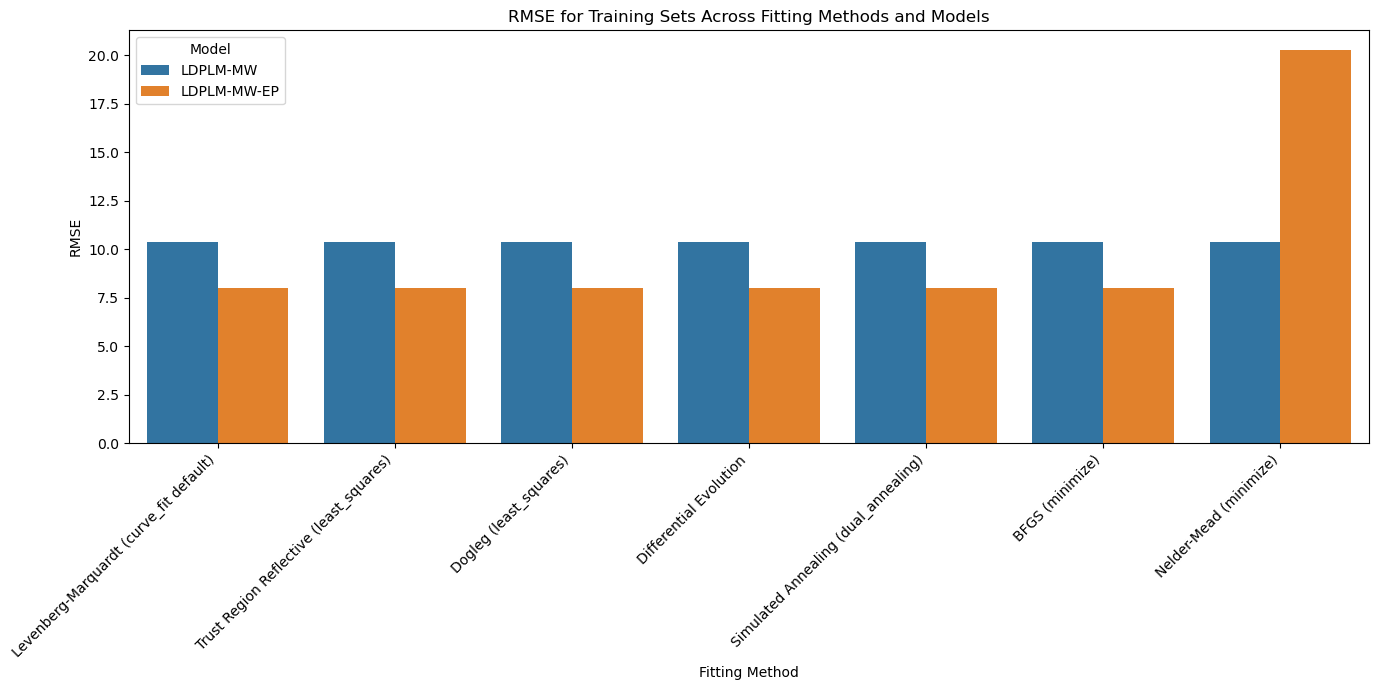

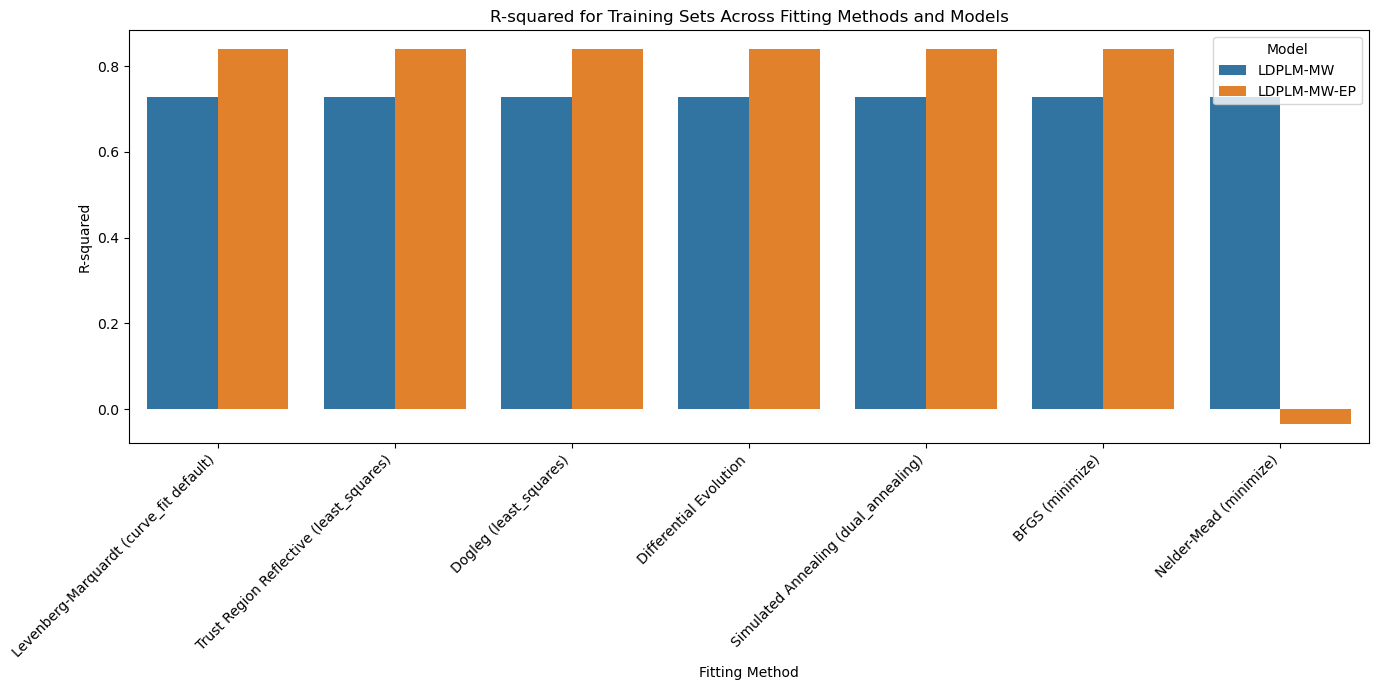

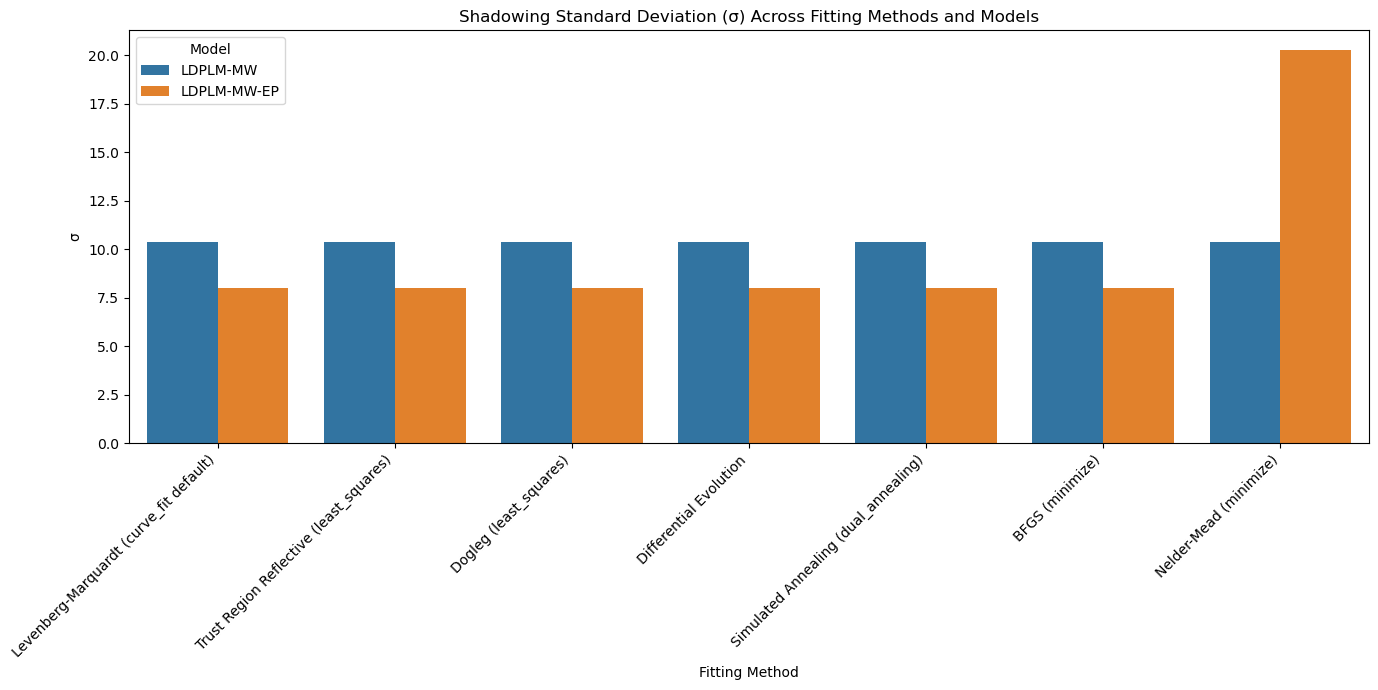

In [12]:
# === Visualization of RMSE and R-squared ===

# Plot RMSE for Training Sets
plt.figure(figsize=(14, 7))
sns.barplot(
    data=final_results, 
    x='Fitting Method', 
    y='RMSE_Train', 
    hue='Model'
)
plt.xticks(rotation=45, ha='right')
plt.title('RMSE for Training Sets Across Fitting Methods and Models')
plt.ylabel('RMSE')
plt.xlabel('Fitting Method')
plt.legend(title='Model')
plt.tight_layout()
plt.show()

# Plot R-squared for Training Sets
plt.figure(figsize=(14, 7))
sns.barplot(
    data=final_results, 
    x='Fitting Method', 
    y='R2_Train', 
    hue='Model'
)
plt.xticks(rotation=45, ha='right')
plt.title('R-squared for Training Sets Across Fitting Methods and Models')
plt.ylabel('R-squared')
plt.xlabel('Fitting Method')
plt.legend(title='Model')
plt.tight_layout()
plt.show()

# Plot Shadowing Sigma for Training Sets
plt.figure(figsize=(14, 7))
sns.barplot(
    data=final_results, 
    x='Fitting Method', 
    y='Shadowing_Sigma', 
    hue='Model'
)
plt.xticks(rotation=45, ha='right')
plt.title('Shadowing Standard Deviation (σ) Across Fitting Methods and Models')
plt.ylabel('σ')
plt.xlabel('Fitting Method')
plt.legend(title='Model')
plt.tight_layout()
plt.show()
